In [36]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import torch 
import torch.nn as nn
import torch.nn.functional as F


import torch.optim as optim

# Getting Data

In [5]:
training_data = np.load("/Users/dj/Documents/GitHub/project-neurocloud/data/training_cats_dogs.npy", allow_pickle = True)
print(len(training_data))

24946


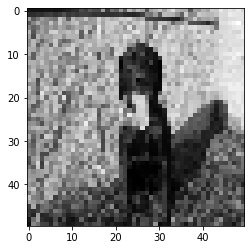

In [17]:
plt.imshow(training_data[0][0], cmap = "gray")
plt.show()

In [19]:
training_data[0][1] # [1,0] = cat, [0,1] = dog

array([0., 1.])

# Neural Network

In [31]:
# Building the neural network

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32, 5) # 1 = input, 32 concolutional feature, 5 = (5,5) kernel size
        self.conv2 = nn.Conv2d(32,64, 5)
        self.conv3 = nn.Conv2d(64,128, 5)

        x = torch.randn(50,50).view(-1, 1,50,50) # -1 = However many input features we have, 1 = one image with shape 50,50 -> Tensor (1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) # We have to run the network one in order to get the number self._to_linear
        self.fc2 = nn.Linear(512, 2) # 2 for cats and dogs

    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2)) # (2,2) = shape of pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))


        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2] # 3 Numbers
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # <- flattening  # We have to run the network one in order to get the number self._to_linear - here as well
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1) # dim = 1 because of the batches | The x comes as a batch of x's | dim = 0 would be everything, 1 is like a column vector cats and dogs

net = Net()

In [33]:
# Define the optimisation and loss method

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50,50)
X = X/255.0 # Right now the pixel values are between 0 and 255, we want to rescale them between 0 and 1
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1 # Lets test against 10% of our data set
val_size = int(len(X) * VAL_PCT)
print(val_size)

2494


In [34]:
# Create train and test set

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [38]:
# Let's train our model

# BATCH_SIZE = 100 # If you get an memory error, lower batch size!
# EPOCHS = 1

# for epoch in range(EPOCHS):
#     for i in tqdm(range(0, len(train_X), BATCH_SIZE)): #from 0 to amount of training data, step size = BATCH_SIZE
#         print(i, i + BATCH_SIZE)

In [39]:
BATCH_SIZE = 100 # If you get an memory error, lower batch size!
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): 
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        # Now we want to do the fitment. Everytime you're going to a fitment/optimisation, you need to 0 the gradients 

        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()


print(loss)

100%|██████████| 225/225 [01:54<00:00,  1.96it/s]

tensor(0.2270, grad_fn=<MseLossBackward0>)


In [40]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]

        #print(real_class, net_out)
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1

print("Accuracy:", round(correct/total,3))

100%|██████████| 2494/2494 [00:05<00:00, 490.33it/s]

Accuracy: 0.64


In [1]:
a = ["a", "b"]

In [2]:
b = a

In [3]:
b[1] = "x"

In [4]:
a

['a', 'x']